In [1]:
import tensorflow as tf

2024-04-06 00:12:12.590544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 00:12:13.843039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(0).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x

def identity_block(x, filters):
    x_identity = x

    x = conv_block(x, filters)
    x = layers.Add()([x, x_identity])
    x = layers.Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), use_bias=False, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)

    x = conv_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "RN_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./RNmodels/'+str(start_epoch-1)+model_name)
else:
    
    input_shape = (30, 30, 168)
    num_classes = 4
    model = resnet18(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-06 00:19:20.249566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14614 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 64)   526848      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 256)    589824      ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 2, 2, 256)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 2, 2, 256)    589824      ['activation_8[0][0]']           
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./RNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-06 00:19:31.390191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


600/600 - 18s - loss: 1.4775 - acc: 0.3862 - val_loss: 1.8773 - val_acc: 0.4000 - 18s/epoch - 29ms/step


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.429375
Confusion Matrix:
[[ 14  12  96 278]
 [  2 149 181  68]
 [  5  84 194 117]
 [  5   2  63 330]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.04      0.07       400
           1       0.60      0.37      0.46       400
           2       0.36      0.48      0.42       400
           3       0.42      0.82      0.55       400

    accuracy                           0.43      1600
   macro avg       0.48      0.43      0.37      1600
weighted avg       0.48      0.43      0.37      1600


Epoch:  2
600/600 - 14s - loss: 1.1340 - acc: 0.4981 - val_loss: 1.1967 - val_acc: 0.4581 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.411875
Confusion Matrix:
[[ 89  63 233  15]
 [  1 267 132   0]
 [  3 182 214   1]
 [ 59  29 223  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.22      0.32       400
           1       0.49      0.67      0.57       400
           2       0.27      0.54      0.36       400
           3       0.85      0.22      0.35       400

    accuracy                           0.41      1600
   macro avg       0.55      0.41      0.40      1600
weighted avg       0.55      0.41      0.40      1600


Epoch:  3
600/600 - 14s - loss: 0.8905 - acc: 0.6192 - val_loss: 1.0212 - val_acc: 0.5825 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.609375
Confusion Matrix:
[[142  37 119 102]
 [ 19 250 106  25]
 [ 24 130 222  24]
 [ 26   4   9 361]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.35      0.46       400
           1       0.59      0.62      0.61       400
           2       0.49      0.56      0.52       400
           3       0.71      0.90      0.79       400

    accuracy                           0.61      1600
   macro avg       0.61      0.61      0.60      1600
weighted avg       0.61      0.61      0.60      1600


Epoch:  4
600/600 - 14s - loss: 0.6354 - acc: 0.7492 - val_loss: 2.0675 - val_acc: 0.3988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.4275
Confusion Matrix:
[[338   7  55   0]
 [138 124 138   0]
 [170  22 208   0]
 [371   4  11  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.84      0.48       400
           1       0.79      0.31      0.45       400
           2       0.50      0.52      0.51       400
           3       1.00      0.04      0.07       400

    accuracy                           0.43      1600
   macro avg       0.66      0.43      0.38      1600
weighted avg       0.66      0.43      0.38      1600


Epoch:  5
600/600 - 14s - loss: 0.4455 - acc: 0.8244 - val_loss: 1.1643 - val_acc: 0.5975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.533125
Confusion Matrix:
[[118  73 209   0]
 [  7 284 109   0]
 [  3 126 271   0]
 [ 84  45  91 180]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.29      0.39       400
           1       0.54      0.71      0.61       400
           2       0.40      0.68      0.50       400
           3       1.00      0.45      0.62       400

    accuracy                           0.53      1600
   macro avg       0.62      0.53      0.53      1600
weighted avg       0.62      0.53      0.53      1600


Epoch:  6
600/600 - 14s - loss: 0.3380 - acc: 0.8692 - val_loss: 3.3794 - val_acc: 0.3531 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.3725
Confusion Matrix:
[[ 13  65 322   0]
 [  1 238 161   0]
 [  0  61 339   0]
 [  4  56 334   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.03      0.06       400
           1       0.57      0.59      0.58       400
           2       0.29      0.85      0.44       400
           3       1.00      0.01      0.03       400

    accuracy                           0.37      1600
   macro avg       0.65      0.37      0.28      1600
weighted avg       0.65      0.37      0.28      1600


Epoch:  7
600/600 - 14s - loss: 0.2805 - acc: 0.8956 - val_loss: 0.9397 - val_acc: 0.6600 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.640625
Confusion Matrix:
[[178  74 148   0]
 [ 21 301  78   0]
 [ 22  90 288   0]
 [ 69  20  53 258]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       400
           1       0.62      0.75      0.68       400
           2       0.51      0.72      0.60       400
           3       1.00      0.65      0.78       400

    accuracy                           0.64      1600
   macro avg       0.69      0.64      0.64      1600
weighted avg       0.69      0.64      0.64      1600


Epoch:  8
600/600 - 14s - loss: 0.2054 - acc: 0.9283 - val_loss: 3.4802 - val_acc: 0.3787 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.335625
Confusion Matrix:
[[ 53 269  78   0]
 [  4 384  12   0]
 [  3 297 100   0]
 [ 68 250  82   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.13      0.20       400
           1       0.32      0.96      0.48       400
           2       0.37      0.25      0.30       400
           3       0.00      0.00      0.00       400

    accuracy                           0.34      1600
   macro avg       0.28      0.34      0.24      1600
weighted avg       0.28      0.34      0.24      1600


Epoch:  9


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.1888 - acc: 0.9294 - val_loss: 1.8876 - val_acc: 0.5387 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.48875
Confusion Matrix:
[[102 103 195   0]
 [  5 328  67   0]
 [  2 128 270   0]
 [ 54  70 194  82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.26      0.36       400
           1       0.52      0.82      0.64       400
           2       0.37      0.68      0.48       400
           3       1.00      0.20      0.34       400

    accuracy                           0.49      1600
   macro avg       0.63      0.49      0.45      1600
weighted avg       0.63      0.49      0.45      1600


Epoch:  10
600/600 - 15s - loss: 0.1629 - acc: 0.9406 - val_loss: 3.0103 - val_acc: 0.5537 - 15s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.58625
Confusion Matrix:
[[316  27   1  56]
 [120 214   0  66]
 [210 103  11  76]
 [  3   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.79      0.60       400
           1       0.62      0.54      0.58       400
           2       0.92      0.03      0.05       400
           3       0.67      0.99      0.80       400

    accuracy                           0.59      1600
   macro avg       0.67      0.59      0.51      1600
weighted avg       0.67      0.59      0.51      1600


Epoch:  11
600/600 - 14s - loss: 0.1380 - acc: 0.9490 - val_loss: 3.5805 - val_acc: 0.5475 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.52
Confusion Matrix:
[[217 105  78   0]
 [ 19 336  45   0]
 [ 20 101 279   0]
 [189  27 184   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       400
           1       0.59      0.84      0.69       400
           2       0.48      0.70      0.57       400
           3       0.00      0.00      0.00       400

    accuracy                           0.52      1600
   macro avg       0.39      0.52      0.44      1600
weighted avg       0.39      0.52      0.44      1600


Epoch:  12


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.1133 - acc: 0.9585 - val_loss: 8.9380 - val_acc: 0.2669 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.26625
Confusion Matrix:
[[  0   1   0 399]
 [  0  23   0 377]
 [  0   1   3 396]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.92      0.06      0.11       400
           2       1.00      0.01      0.01       400
           3       0.25      1.00      0.41       400

    accuracy                           0.27      1600
   macro avg       0.54      0.27      0.13      1600
weighted avg       0.54      0.27      0.13      1600


Epoch:  13


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.1104 - acc: 0.9633 - val_loss: 3.1778 - val_acc: 0.4475 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.4175
Confusion Matrix:
[[221 177   2   0]
 [  9 391   0   0]
 [ 41 348  11   0]
 [232 116   7  45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       400
           1       0.38      0.98      0.55       400
           2       0.55      0.03      0.05       400
           3       1.00      0.11      0.20       400

    accuracy                           0.42      1600
   macro avg       0.59      0.42      0.32      1600
weighted avg       0.59      0.42      0.32      1600


Epoch:  14
600/600 - 14s - loss: 0.0951 - acc: 0.9652 - val_loss: 1.8150 - val_acc: 0.6356 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.615625
Confusion Matrix:
[[ 82 280  28  10]
 [  1 396   2   1]
 [  1 282 115   2]
 [  0   8   0 392]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.20      0.34       400
           1       0.41      0.99      0.58       400
           2       0.79      0.29      0.42       400
           3       0.97      0.98      0.97       400

    accuracy                           0.62      1600
   macro avg       0.79      0.62      0.58      1600
weighted avg       0.79      0.62      0.58      1600


Epoch:  15
600/600 - 14s - loss: 0.1055 - acc: 0.9631 - val_loss: 0.7594 - val_acc: 0.7887 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.78
Confusion Matrix:
[[288  85  25   2]
 [ 36 341  18   5]
 [ 56 112 231   1]
 [ 10   2   0 388]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       400
           1       0.63      0.85      0.73       400
           2       0.84      0.58      0.69       400
           3       0.98      0.97      0.97       400

    accuracy                           0.78      1600
   macro avg       0.80      0.78      0.78      1600
weighted avg       0.80      0.78      0.78      1600


Epoch:  16
600/600 - 14s - loss: 0.0832 - acc: 0.9721 - val_loss: 2.4861 - val_acc: 0.5931 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.594375
Confusion Matrix:
[[368  32   0   0]
 [122 278   0   0]
 [192 186  22   0]
 [113   4   0 283]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.92      0.62       400
           1       0.56      0.69      0.62       400
           2       1.00      0.06      0.10       400
           3       1.00      0.71      0.83       400

    accuracy                           0.59      1600
   macro avg       0.75      0.59      0.54      1600
weighted avg       0.75      0.59      0.54      1600


Epoch:  17
600/600 - 14s - loss: 0.0754 - acc: 0.9740 - val_loss: 1.4864 - val_acc: 0.6169 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.60875
Confusion Matrix:
[[131  27  53 189]
 [ 30 220  31 119]
 [  7  32 223 138]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.33      0.46       400
           1       0.79      0.55      0.65       400
           2       0.73      0.56      0.63       400
           3       0.47      1.00      0.64       400

    accuracy                           0.61      1600
   macro avg       0.69      0.61      0.60      1600
weighted avg       0.69      0.61      0.60      1600


Epoch:  18
600/600 - 14s - loss: 0.0676 - acc: 0.9771 - val_loss: 4.9646 - val_acc: 0.4606 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.40625
Confusion Matrix:
[[268 132   0   0]
 [ 33 367   0   0]
 [103 297   0   0]
 [238 147   0  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.67      0.51       400
           1       0.39      0.92      0.55       400
           2       0.00      0.00      0.00       400
           3       1.00      0.04      0.07       400

    accuracy                           0.41      1600
   macro avg       0.45      0.41      0.28      1600
weighted avg       0.45      0.41      0.28      1600


Epoch:  19


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0757 - acc: 0.9735 - val_loss: 2.1342 - val_acc: 0.6406 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.578125
Confusion Matrix:
[[112 286   2   0]
 [  1 398   1   0]
 [  5 331  64   0]
 [  6  43   0 351]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.28      0.43       400
           1       0.38      0.99      0.55       400
           2       0.96      0.16      0.27       400
           3       1.00      0.88      0.93       400

    accuracy                           0.58      1600
   macro avg       0.81      0.58      0.55      1600
weighted avg       0.81      0.58      0.55      1600


Epoch:  20
600/600 - 14s - loss: 0.0615 - acc: 0.9781 - val_loss: 1.2290 - val_acc: 0.6775 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.675
Confusion Matrix:
[[250  11 110  29]
 [ 62 118  80 140]
 [ 31  15 313  41]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       400
           1       0.82      0.29      0.43       400
           2       0.62      0.78      0.69       400
           3       0.66      1.00      0.79       400

    accuracy                           0.68      1600
   macro avg       0.71      0.68      0.65      1600
weighted avg       0.71      0.68      0.65      1600


Epoch:  21
600/600 - 14s - loss: 0.0539 - acc: 0.9844 - val_loss: 6.3241 - val_acc: 0.3738 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.3925
Confusion Matrix:
[[396   4   0   0]
 [225 174   1   0]
 [292  50  58   0]
 [388   0  12   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.99      0.47       400
           1       0.76      0.43      0.55       400
           2       0.82      0.14      0.25       400
           3       0.00      0.00      0.00       400

    accuracy                           0.39      1600
   macro avg       0.47      0.39      0.32      1600
weighted avg       0.47      0.39      0.32      1600


Epoch:  22


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0474 - acc: 0.9842 - val_loss: 6.1103 - val_acc: 0.3106 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.30125
Confusion Matrix:
[[  1 356  43   0]
 [  0 395   5   0]
 [  0 314  86   0]
 [  1 349  50   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       400
           1       0.28      0.99      0.44       400
           2       0.47      0.21      0.29       400
           3       0.00      0.00      0.00       400

    accuracy                           0.30      1600
   macro avg       0.31      0.30      0.18      1600
weighted avg       0.31      0.30      0.18      1600


Epoch:  23


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0647 - acc: 0.9787 - val_loss: 1.5115 - val_acc: 0.7337 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.7575
Confusion Matrix:
[[352  41   7   0]
 [ 99 298   3   0]
 [120 114 166   0]
 [  4   0   0 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       400
           1       0.66      0.74      0.70       400
           2       0.94      0.41      0.58       400
           3       1.00      0.99      0.99       400

    accuracy                           0.76      1600
   macro avg       0.80      0.76      0.75      1600
weighted avg       0.80      0.76      0.75      1600


Epoch:  24
600/600 - 14s - loss: 0.0549 - acc: 0.9819 - val_loss: 3.8435 - val_acc: 0.5750 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.55625
Confusion Matrix:
[[ 96 223   0  81]
 [  1 391   0   8]
 [ 20 336   3  41]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.24      0.37       400
           1       0.41      0.98      0.58       400
           2       1.00      0.01      0.01       400
           3       0.75      1.00      0.86       400

    accuracy                           0.56      1600
   macro avg       0.75      0.56      0.46      1600
weighted avg       0.75      0.56      0.46      1600


Epoch:  25
600/600 - 14s - loss: 0.0550 - acc: 0.9825 - val_loss: 0.8308 - val_acc: 0.7856 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.708125
Confusion Matrix:
[[147 199  50   4]
 [  8 381  11   0]
 [  3 137 260   0]
 [  4  42   9 345]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.37      0.52       400
           1       0.50      0.95      0.66       400
           2       0.79      0.65      0.71       400
           3       0.99      0.86      0.92       400

    accuracy                           0.71      1600
   macro avg       0.80      0.71      0.70      1600
weighted avg       0.80      0.71      0.70      1600


Epoch:  26
600/600 - 14s - loss: 0.0474 - acc: 0.9819 - val_loss: 1.6025 - val_acc: 0.6456 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.62
Confusion Matrix:
[[145  91   9 155]
 [  8 326   5  61]
 [ 13  93 121 173]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.36      0.51       400
           1       0.64      0.81      0.72       400
           2       0.90      0.30      0.45       400
           3       0.51      1.00      0.67       400

    accuracy                           0.62      1600
   macro avg       0.73      0.62      0.59      1600
weighted avg       0.73      0.62      0.59      1600


Epoch:  27
600/600 - 14s - loss: 0.0254 - acc: 0.9925 - val_loss: 2.0454 - val_acc: 0.6562 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.61
Confusion Matrix:
[[ 78 320   2   0]
 [  0 400   0   0]
 [  0 298  98   4]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33       400
           1       0.39      1.00      0.56       400
           2       0.98      0.24      0.39       400
           3       0.99      1.00      1.00       400

    accuracy                           0.61      1600
   macro avg       0.84      0.61      0.57      1600
weighted avg       0.84      0.61      0.57      1600


Epoch:  28
600/600 - 14s - loss: 0.0822 - acc: 0.9746 - val_loss: 25.4316 - val_acc: 0.2506 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.25
Confusion Matrix:
[[  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       400
           3       0.25      1.00      0.40       400

    accuracy                           0.25      1600
   macro avg       0.06      0.25      0.10      1600
weighted avg       0.06      0.25      0.10      1600


Epoch:  29


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0308 - acc: 0.9906 - val_loss: 2.8934 - val_acc: 0.6306 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.60125
Confusion Matrix:
[[281 119   0   0]
 [ 31 369   0   0]
 [122 263  15   0]
 [ 76  27   0 297]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.62       400
           1       0.47      0.92      0.63       400
           2       1.00      0.04      0.07       400
           3       1.00      0.74      0.85       400

    accuracy                           0.60      1600
   macro avg       0.76      0.60      0.54      1600
weighted avg       0.76      0.60      0.54      1600


Epoch:  30
600/600 - 14s - loss: 0.0262 - acc: 0.9919 - val_loss: 1.8442 - val_acc: 0.6581 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.650625
Confusion Matrix:
[[164  91  15 130]
 [ 26 327  11  36]
 [ 17  71 152 160]
 [  0   2   0 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       400
           1       0.67      0.82      0.73       400
           2       0.85      0.38      0.53       400
           3       0.55      0.99      0.71       400

    accuracy                           0.65      1600
   macro avg       0.72      0.65      0.63      1600
weighted avg       0.72      0.65      0.63      1600


Epoch:  31
600/600 - 14s - loss: 0.0551 - acc: 0.9819 - val_loss: 7.3344 - val_acc: 0.3719 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.32375
Confusion Matrix:
[[ 74 326   0   0]
 [  0 400   0   0]
 [  2 398   0   0]
 [ 19 337   0  44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.18      0.30       400
           1       0.27      1.00      0.43       400
           2       0.00      0.00      0.00       400
           3       1.00      0.11      0.20       400

    accuracy                           0.32      1600
   macro avg       0.51      0.32      0.23      1600
weighted avg       0.51      0.32      0.23      1600


Epoch:  32


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0265 - acc: 0.9912 - val_loss: 4.3904 - val_acc: 0.4069 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.403125
Confusion Matrix:
[[  6   4   7 383]
 [ 10 155  20 215]
 [  0   2  84 314]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.01      0.03       400
           1       0.96      0.39      0.55       400
           2       0.76      0.21      0.33       400
           3       0.30      1.00      0.47       400

    accuracy                           0.40      1600
   macro avg       0.60      0.40      0.34      1600
weighted avg       0.60      0.40      0.34      1600


Epoch:  33
600/600 - 14s - loss: 0.0797 - acc: 0.9748 - val_loss: 6.2172 - val_acc: 0.3081 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.299375
Confusion Matrix:
[[ 38 362   0   0]
 [  0 400   0   0]
 [  1 358  41   0]
 [  9 381  10   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.10      0.17       400
           1       0.27      1.00      0.42       400
           2       0.80      0.10      0.18       400
           3       0.00      0.00      0.00       400

    accuracy                           0.30      1600
   macro avg       0.47      0.30      0.19      1600
weighted avg       0.47      0.30      0.19      1600


Epoch:  34


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0226 - acc: 0.9931 - val_loss: 0.5924 - val_acc: 0.8506 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.81125
Confusion Matrix:
[[222  24 152   2]
 [ 31 299  70   0]
 [  1  21 378   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.56      0.68       400
           1       0.87      0.75      0.80       400
           2       0.63      0.94      0.76       400
           3       1.00      1.00      1.00       400

    accuracy                           0.81      1600
   macro avg       0.84      0.81      0.81      1600
weighted avg       0.84      0.81      0.81      1600


Epoch:  35
600/600 - 14s - loss: 0.0029 - acc: 0.9996 - val_loss: 0.5208 - val_acc: 0.8656 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.81
Confusion Matrix:
[[202  58 140   0]
 [ 17 342  41   0]
 [  2  43 354   1]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.77      0.85      0.81       400
           2       0.66      0.89      0.76       400
           3       1.00      0.99      1.00       400

    accuracy                           0.81      1600
   macro avg       0.83      0.81      0.80      1600
weighted avg       0.83      0.81      0.80      1600


Epoch:  36
600/600 - 14s - loss: 5.9422e-04 - acc: 1.0000 - val_loss: 0.4444 - val_acc: 0.8963 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.828125
Confusion Matrix:
[[228  92  80   0]
 [ 14 364  22   0]
 [  3  53 344   0]
 [  7   1   3 389]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       400
           1       0.71      0.91      0.80       400
           2       0.77      0.86      0.81       400
           3       1.00      0.97      0.99       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  37
600/600 - 14s - loss: 2.6147e-04 - acc: 1.0000 - val_loss: 0.4491 - val_acc: 0.8975 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.831875
Confusion Matrix:
[[221  79 100   0]
 [ 12 362  26   0]
 [  2  48 350   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.55      0.69       400
           1       0.74      0.91      0.81       400
           2       0.73      0.88      0.80       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  38
600/600 - 14s - loss: 1.7855e-04 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.9000 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.82875
Confusion Matrix:
[[217  79 104   0]
 [ 13 360  27   0]
 [  2  47 351   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69       400
           1       0.74      0.90      0.81       400
           2       0.73      0.88      0.80       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  39
600/600 - 14s - loss: 1.3083e-04 - acc: 1.0000 - val_loss: 0.4703 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.82875
Confusion Matrix:
[[218  78 104   0]
 [ 13 359  28   0]
 [  2  47 351   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69       400
           1       0.74      0.90      0.81       400
           2       0.73      0.88      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  40
600/600 - 14s - loss: 9.7696e-05 - acc: 1.0000 - val_loss: 0.4811 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.8275
Confusion Matrix:
[[216  77 107   0]
 [ 13 359  28   0]
 [  2  47 351   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.68       400
           1       0.74      0.90      0.81       400
           2       0.72      0.88      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  41
600/600 - 14s - loss: 7.3506e-05 - acc: 1.0000 - val_loss: 0.4923 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.828125
Confusion Matrix:
[[216  77 107   0]
 [ 12 359  29   0]
 [  2  46 352   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68       400
           1       0.74      0.90      0.81       400
           2       0.72      0.88      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  42
600/600 - 13s - loss: 5.5503e-05 - acc: 1.0000 - val_loss: 0.5034 - val_acc: 0.9019 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.82875
Confusion Matrix:
[[216  76 108   0]
 [ 12 359  29   0]
 [  2  45 353   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68       400
           1       0.75      0.90      0.82       400
           2       0.72      0.88      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  43
600/600 - 14s - loss: 4.1953e-05 - acc: 1.0000 - val_loss: 0.5157 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8275
Confusion Matrix:
[[214  74 112   0]
 [ 12 358  30   0]
 [  2  44 354   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.68       400
           1       0.75      0.90      0.82       400
           2       0.71      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  44
600/600 - 14s - loss: 3.1730e-05 - acc: 1.0000 - val_loss: 0.5281 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.826875
Confusion Matrix:
[[213  74 113   0]
 [ 11 358  31   0]
 [  2  44 354   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       400
           1       0.75      0.90      0.82       400
           2       0.71      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  45
600/600 - 14s - loss: 2.3964e-05 - acc: 1.0000 - val_loss: 0.5408 - val_acc: 0.8981 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8275
Confusion Matrix:
[[213  74 113   0]
 [ 12 358  30   0]
 [  2  43 355   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.53      0.68       400
           1       0.75      0.90      0.82       400
           2       0.71      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  46
600/600 - 14s - loss: 1.8062e-05 - acc: 1.0000 - val_loss: 0.5540 - val_acc: 0.8975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.828125
Confusion Matrix:
[[214  70 116   0]
 [ 12 358  30   0]
 [  2  43 355   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.68       400
           1       0.76      0.90      0.82       400
           2       0.71      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  47
600/600 - 14s - loss: 1.3578e-05 - acc: 1.0000 - val_loss: 0.5675 - val_acc: 0.8963 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.830625
Confusion Matrix:
[[215  69 116   0]
 [ 12 358  30   0]
 [  2  40 358   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.68       400
           1       0.77      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  48
600/600 - 14s - loss: 1.0189e-05 - acc: 1.0000 - val_loss: 0.5815 - val_acc: 0.8956 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.831875
Confusion Matrix:
[[215  69 116   0]
 [ 11 359  30   0]
 [  2  39 359   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68       400
           1       0.77      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  49
600/600 - 14s - loss: 7.6365e-06 - acc: 1.0000 - val_loss: 0.5949 - val_acc: 0.8981 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.830625
Confusion Matrix:
[[213  70 117   0]
 [ 11 359  30   0]
 [  2  39 359   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       400
           1       0.77      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  50
600/600 - 14s - loss: 5.7155e-06 - acc: 1.0000 - val_loss: 0.6088 - val_acc: 0.8975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.830625
Confusion Matrix:
[[213  72 115   0]
 [ 11 359  30   0]
 [  2  39 359   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       400
           1       0.76      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  51
600/600 - 14s - loss: 4.2810e-06 - acc: 1.0000 - val_loss: 0.6227 - val_acc: 0.8981 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.829375
Confusion Matrix:
[[211  71 118   0]
 [ 11 359  30   0]
 [  2  39 359   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       400
           1       0.77      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  52
600/600 - 14s - loss: 3.1940e-06 - acc: 1.0000 - val_loss: 0.6376 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.82875
Confusion Matrix:
[[210  71 119   0]
 [ 11 359  30   0]
 [  2  39 359   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.67       400
           1       0.77      0.90      0.83       400
           2       0.71      0.90      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  53
600/600 - 14s - loss: 2.4172e-06 - acc: 1.0000 - val_loss: 0.6473 - val_acc: 0.8994 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.82875
Confusion Matrix:
[[213  75 112   0]
 [ 11 359  30   0]
 [  2  42 356   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       400
           1       0.75      0.90      0.82       400
           2       0.71      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  54
600/600 - 14s - loss: 1.9894e-06 - acc: 1.0000 - val_loss: 0.6675 - val_acc: 0.8975 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 1s 10ms/step
Accuracy: 0.82625
Confusion Matrix:
[[209  72 119   0]
 [ 11 358  31   0]
 [  2  41 357   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.52      0.67       400
           1       0.76      0.90      0.82       400
           2       0.70      0.89      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.82      1600
weighted avg       0.85      0.83      0.82      1600


Epoch:  55
600/600 - 14s - loss: 0.2555 - acc: 0.9340 - val_loss: 5.2352 - val_acc: 0.4450 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.398125
Confusion Matrix:
[[261 139   0   0]
 [ 29 371   0   0]
 [ 78 318   4   0]
 [298 101   0   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.65      0.49       400
           1       0.40      0.93      0.56       400
           2       1.00      0.01      0.02       400
           3       1.00      0.00      0.00       400

    accuracy                           0.40      1600
   macro avg       0.70      0.40      0.27      1600
weighted avg       0.70      0.40      0.27      1600


Epoch:  56
600/600 - 14s - loss: 0.0583 - acc: 0.9810 - val_loss: 3.9575 - val_acc: 0.5537 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.554375
Confusion Matrix:
[[329  61  10   0]
 [ 79 319   2   0]
 [ 48 113 239   0]
 [287  45  68   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.82      0.58       400
           1       0.59      0.80      0.68       400
           2       0.75      0.60      0.66       400
           3       0.00      0.00      0.00       400

    accuracy                           0.55      1600
   macro avg       0.45      0.55      0.48      1600
weighted avg       0.45      0.55      0.48      1600


Epoch:  57


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0091 - acc: 0.9979 - val_loss: 0.6565 - val_acc: 0.8481 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8125
Confusion Matrix:
[[265 113  22   0]
 [ 24 370   6   0]
 [ 23  82 295   0]
 [ 23   3   4 370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       400
           1       0.65      0.93      0.76       400
           2       0.90      0.74      0.81       400
           3       1.00      0.93      0.96       400

    accuracy                           0.81      1600
   macro avg       0.84      0.81      0.81      1600
weighted avg       0.84      0.81      0.81      1600


Epoch:  58
600/600 - 14s - loss: 0.0205 - acc: 0.9925 - val_loss: 4.5922 - val_acc: 0.4231 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.43125
Confusion Matrix:
[[ 13  15 372   0]
 [  1 258 141   0]
 [  0  12 388   0]
 [  3   2 364  31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.03      0.06       400
           1       0.90      0.65      0.75       400
           2       0.31      0.97      0.47       400
           3       1.00      0.08      0.14       400

    accuracy                           0.43      1600
   macro avg       0.74      0.43      0.36      1600
weighted avg       0.74      0.43      0.36      1600


Epoch:  59
600/600 - 14s - loss: 0.0399 - acc: 0.9877 - val_loss: 2.7147 - val_acc: 0.5900 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.63
Confusion Matrix:
[[ 23   4 358  15]
 [  7 192 199   2]
 [  0   3 397   0]
 [  0   0   4 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.06      0.11       400
           1       0.96      0.48      0.64       400
           2       0.41      0.99      0.58       400
           3       0.96      0.99      0.97       400

    accuracy                           0.63      1600
   macro avg       0.78      0.63      0.58      1600
weighted avg       0.78      0.63      0.58      1600


Epoch:  60
600/600 - 14s - loss: 0.0492 - acc: 0.9831 - val_loss: 0.8520 - val_acc: 0.8006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.75875
Confusion Matrix:
[[237 151  12   0]
 [ 18 382   0   0]
 [ 23 166 211   0]
 [ 11   5   0 384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       400
           1       0.54      0.95      0.69       400
           2       0.95      0.53      0.68       400
           3       1.00      0.96      0.98       400

    accuracy                           0.76      1600
   macro avg       0.83      0.76      0.76      1600
weighted avg       0.83      0.76      0.76      1600


Epoch:  61
600/600 - 14s - loss: 0.0184 - acc: 0.9937 - val_loss: 2.5450 - val_acc: 0.6762 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.613125
Confusion Matrix:
[[228 172   0   0]
 [ 14 386   0   0]
 [ 66 299  35   0]
 [ 58  10   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       400
           1       0.45      0.96      0.61       400
           2       1.00      0.09      0.16       400
           3       1.00      0.83      0.91       400

    accuracy                           0.61      1600
   macro avg       0.77      0.61      0.57      1600
weighted avg       0.77      0.61      0.57      1600


Epoch:  62
600/600 - 14s - loss: 0.0372 - acc: 0.9890 - val_loss: 1.8247 - val_acc: 0.6313 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.555
Confusion Matrix:
[[158  47 195   0]
 [  7 337  56   0]
 [  0  35 365   0]
 [ 38  16 318  28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.40      0.52       400
           1       0.77      0.84      0.81       400
           2       0.39      0.91      0.55       400
           3       1.00      0.07      0.13       400

    accuracy                           0.56      1600
   macro avg       0.74      0.55      0.50      1600
weighted avg       0.74      0.56      0.50      1600


Epoch:  63
600/600 - 14s - loss: 0.0171 - acc: 0.9942 - val_loss: 4.6930 - val_acc: 0.4006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.39375
Confusion Matrix:
[[  0   4   8 388]
 [  0 103   7 290]
 [  0   8 127 265]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.90      0.26      0.40       400
           2       0.89      0.32      0.47       400
           3       0.30      1.00      0.46       400

    accuracy                           0.39      1600
   macro avg       0.52      0.39      0.33      1600
weighted avg       0.52      0.39      0.33      1600


Epoch:  64


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0337 - acc: 0.9885 - val_loss: 4.4352 - val_acc: 0.5931 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.53875
Confusion Matrix:
[[ 84 312   0   4]
 [  1 399   0   0]
 [  8 385   6   1]
 [  0  27   0 373]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.21      0.34       400
           1       0.36      1.00      0.52       400
           2       1.00      0.01      0.03       400
           3       0.99      0.93      0.96       400

    accuracy                           0.54      1600
   macro avg       0.81      0.54      0.46      1600
weighted avg       0.81      0.54      0.46      1600


Epoch:  65
600/600 - 14s - loss: 0.0435 - acc: 0.9867 - val_loss: 2.1476 - val_acc: 0.5325 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.508125
Confusion Matrix:
[[213 185   2   0]
 [ 12 388   0   0]
 [ 34 213 153   0]
 [238  79  24  59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.53      0.47       400
           1       0.45      0.97      0.61       400
           2       0.85      0.38      0.53       400
           3       1.00      0.15      0.26       400

    accuracy                           0.51      1600
   macro avg       0.68      0.51      0.47      1600
weighted avg       0.68      0.51      0.47      1600


Epoch:  66
600/600 - 14s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.8141 - val_acc: 0.8169 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.7975
Confusion Matrix:
[[204  30 153  13]
 [ 26 294  77   3]
 [  3  17 378   2]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.51      0.64       400
           1       0.86      0.73      0.79       400
           2       0.62      0.94      0.75       400
           3       0.96      1.00      0.98       400

    accuracy                           0.80      1600
   macro avg       0.83      0.80      0.79      1600
weighted avg       0.83      0.80      0.79      1600


Epoch:  67
600/600 - 14s - loss: 0.0030 - acc: 0.9994 - val_loss: 0.5124 - val_acc: 0.8894 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.80625
Confusion Matrix:
[[179 131  90   0]
 [  8 372  20   0]
 [  4  54 342   0]
 [  1   0   2 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.45      0.60       400
           1       0.67      0.93      0.78       400
           2       0.75      0.85      0.80       400
           3       1.00      0.99      1.00       400

    accuracy                           0.81      1600
   macro avg       0.84      0.81      0.79      1600
weighted avg       0.84      0.81      0.79      1600


Epoch:  68
600/600 - 14s - loss: 0.0527 - acc: 0.9800 - val_loss: 6.5359 - val_acc: 0.4238 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.41125
Confusion Matrix:
[[371  29   0   0]
 [117 283   0   0]
 [270 126   4   0]
 [399   0   1   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.93      0.48       400
           1       0.65      0.71      0.68       400
           2       0.80      0.01      0.02       400
           3       0.00      0.00      0.00       400

    accuracy                           0.41      1600
   macro avg       0.44      0.41      0.29      1600
weighted avg       0.44      0.41      0.29      1600


Epoch:  69


/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

600/600 - 14s - loss: 0.0208 - acc: 0.9931 - val_loss: 0.8869 - val_acc: 0.8300 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.791875
Confusion Matrix:
[[226  10 164   0]
 [ 44 259  97   0]
 [  3  14 383   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.56      0.67       400
           1       0.92      0.65      0.76       400
           2       0.59      0.96      0.73       400
           3       1.00      1.00      1.00       400

    accuracy                           0.79      1600
   macro avg       0.83      0.79      0.79      1600
weighted avg       0.83      0.79      0.79      1600


Epoch:  70
600/600 - 14s - loss: 0.0035 - acc: 0.9990 - val_loss: 0.6429 - val_acc: 0.8575 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.81875
Confusion Matrix:
[[245  20 134   1]
 [ 47 290  60   3]
 [ 10  15 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.70       400
           1       0.89      0.72      0.80       400
           2       0.66      0.94      0.77       400
           3       0.99      1.00      1.00       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.82      1600
weighted avg       0.84      0.82      0.82      1600


Epoch:  71
600/600 - 14s - loss: 5.3108e-04 - acc: 1.0000 - val_loss: 0.4476 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8375
Confusion Matrix:
[[233  66 101   0]
 [ 19 350  31   0]
 [  8  35 357   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.71       400
           1       0.78      0.88      0.82       400
           2       0.73      0.89      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  72
600/600 - 14s - loss: 1.8838e-04 - acc: 1.0000 - val_loss: 0.4485 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.835625
Confusion Matrix:
[[229  72  99   0]
 [ 19 352  29   0]
 [  8  35 357   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.70       400
           1       0.77      0.88      0.82       400
           2       0.73      0.89      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  73
600/600 - 14s - loss: 1.3349e-04 - acc: 1.0000 - val_loss: 0.4536 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.83625
Confusion Matrix:
[[229  72  99   0]
 [ 18 354  28   0]
 [  8  36 356   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       400
           1       0.77      0.89      0.82       400
           2       0.74      0.89      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  74
600/600 - 14s - loss: 1.0004e-04 - acc: 1.0000 - val_loss: 0.4604 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.835625
Confusion Matrix:
[[228  73  99   0]
 [ 18 355  27   0]
 [  9  36 355   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.70       400
           1       0.77      0.89      0.82       400
           2       0.74      0.89      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  75
600/600 - 14s - loss: 7.6153e-05 - acc: 1.0000 - val_loss: 0.4676 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.83625
Confusion Matrix:
[[228  72 100   0]
 [ 17 356  27   0]
 [  9  36 355   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       400
           1       0.77      0.89      0.82       400
           2       0.73      0.89      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  76
600/600 - 14s - loss: 5.8413e-05 - acc: 1.0000 - val_loss: 0.4757 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.835
Confusion Matrix:
[[227  72 101   0]
 [ 17 355  28   0]
 [  9  36 355   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       400
           1       0.77      0.89      0.82       400
           2       0.73      0.89      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  77
600/600 - 14s - loss: 4.4867e-05 - acc: 1.0000 - val_loss: 0.4842 - val_acc: 0.9019 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.835
Confusion Matrix:
[[226  73 101   0]
 [ 18 355  27   0]
 [  9  35 356   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       400
           1       0.77      0.89      0.82       400
           2       0.73      0.89      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  78
600/600 - 14s - loss: 3.4416e-05 - acc: 1.0000 - val_loss: 0.4931 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.83625
Confusion Matrix:
[[226  73 101   0]
 [ 18 356  26   0]
 [  9  34 357   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       400
           1       0.77      0.89      0.83       400
           2       0.74      0.89      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  79
600/600 - 14s - loss: 2.6358e-05 - acc: 1.0000 - val_loss: 0.5024 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8375
Confusion Matrix:
[[227  73 100   0]
 [ 18 356  26   0]
 [  9  33 358   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.69       400
           1       0.77      0.89      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  80
600/600 - 14s - loss: 2.0130e-05 - acc: 1.0000 - val_loss: 0.5120 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.838125
Confusion Matrix:
[[227  73 100   0]
 [ 17 357  26   0]
 [  9  33 358   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       400
           1       0.77      0.89      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  81
600/600 - 14s - loss: 1.5333e-05 - acc: 1.0000 - val_loss: 0.5224 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.836875
Confusion Matrix:
[[224  74 102   0]
 [ 17 358  25   0]
 [  9  33 358   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  82
600/600 - 14s - loss: 1.1652e-05 - acc: 1.0000 - val_loss: 0.5331 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.8375
Confusion Matrix:
[[224  74 102   0]
 [ 17 358  25   0]
 [  8  33 359   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  83
600/600 - 14s - loss: 8.8262e-06 - acc: 1.0000 - val_loss: 0.5439 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.83875
Confusion Matrix:
[[224  74 102   0]
 [ 17 359  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  84
600/600 - 14s - loss: 6.6707e-06 - acc: 1.0000 - val_loss: 0.5552 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.836875
Confusion Matrix:
[[221  75 104   0]
 [ 17 359  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  85
600/600 - 14s - loss: 5.0290e-06 - acc: 1.0000 - val_loss: 0.5671 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8375
Confusion Matrix:
[[222  74 104   0]
 [ 17 359  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  86
600/600 - 14s - loss: 3.7801e-06 - acc: 1.0000 - val_loss: 0.5786 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.836875
Confusion Matrix:
[[221  75 104   0]
 [ 17 359  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  87
600/600 - 14s - loss: 2.8374e-06 - acc: 1.0000 - val_loss: 0.5903 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.8375
Confusion Matrix:
[[222  75 103   0]
 [ 17 359  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  88
600/600 - 14s - loss: 2.1279e-06 - acc: 1.0000 - val_loss: 0.6018 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8375
Confusion Matrix:
[[221  76 103   0]
 [ 16 360  24   0]
 [  7  33 360   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  89
600/600 - 14s - loss: 1.5924e-06 - acc: 1.0000 - val_loss: 0.6140 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.838125
Confusion Matrix:
[[221  76 103   0]
 [ 16 360  24   0]
 [  6  33 361   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  90
600/600 - 14s - loss: 1.1873e-06 - acc: 1.0000 - val_loss: 0.6264 - val_acc: 0.9044 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.8375
Confusion Matrix:
[[221  76 103   0]
 [ 17 359  24   0]
 [  6  33 361   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  91
600/600 - 14s - loss: 8.8485e-07 - acc: 1.0000 - val_loss: 0.6385 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.839375
Confusion Matrix:
[[222  76 102   0]
 [ 17 360  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  92
600/600 - 14s - loss: 6.5947e-07 - acc: 1.0000 - val_loss: 0.6512 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.839375
Confusion Matrix:
[[222  76 102   0]
 [ 17 360  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  93
600/600 - 14s - loss: 4.9059e-07 - acc: 1.0000 - val_loss: 0.6641 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.83875
Confusion Matrix:
[[222  76 102   0]
 [ 17 359  24   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  94
600/600 - 14s - loss: 3.6443e-07 - acc: 1.0000 - val_loss: 0.6757 - val_acc: 0.9050 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.84
Confusion Matrix:
[[222  76 102   0]
 [ 17 361  22   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  95
600/600 - 14s - loss: 2.7075e-07 - acc: 1.0000 - val_loss: 0.6881 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.839375
Confusion Matrix:
[[222  76 102   0]
 [ 17 360  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  96
600/600 - 14s - loss: 2.0017e-07 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.9031 - 14s/epoch - 24ms/step


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.840625
Confusion Matrix:
[[222  76 102   0]
 [ 15 362  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.91      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.83      1600
weighted avg       0.86      0.84      0.83      1600


Epoch:  97
600/600 - 14s - loss: 1.4906e-07 - acc: 1.0000 - val_loss: 0.7124 - val_acc: 0.9019 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.84125
Confusion Matrix:
[[224  74 102   0]
 [ 16 361  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  98
600/600 - 14s - loss: 1.1141e-07 - acc: 1.0000 - val_loss: 0.7260 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.84125
Confusion Matrix:
[[224  74 102   0]
 [ 16 361  23   0]
 [  6  33 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.74      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  99
600/600 - 14s - loss: 8.7023e-08 - acc: 1.0000 - val_loss: 0.7329 - val_acc: 0.9044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.84
Confusion Matrix:
[[223  77 100   0]
 [ 17 361  22   0]
 [  7  33 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       400
           1       0.77      0.90      0.83       400
           2       0.75      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.83      1600
weighted avg       0.85      0.84      0.83      1600


Epoch:  100
600/600 - 14s - loss: 0.1393 - acc: 0.9627 - val_loss: 6.4866 - val_acc: 0.4387 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.406875
Confusion Matrix:
[[280 120   0   0]
 [ 30 370   0   0]
 [ 63 336   1   0]
 [229 171   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       400
           1       0.37      0.93      0.53       400
           2       1.00      0.00      0.00       400
           3       0.00      0.00      0.00       400

    accuracy                           0.41      1600
   macro avg       0.46      0.41      0.27      1600
weighted avg       0.46      0.41      0.27      1600

Testing time (s) = 2986.300165721914



/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 1s 12ms/step
Accuracy: 0.406875
Confusion Matrix:
[[280 120   0   0]
 [ 30 370   0   0]
 [ 63 336   1   0]
 [229 171   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       400
           1       0.37      0.93      0.53       400
           2       1.00      0.00      0.00       400
           3       0.00      0.00      0.00       400

    accuracy                           0.41      1600
   macro avg       0.46      0.41      0.27      1600
weighted avg       0.46      0.41      0.27      1600



/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/Desktop/Deepak/Wheat-Classification/dwheatenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

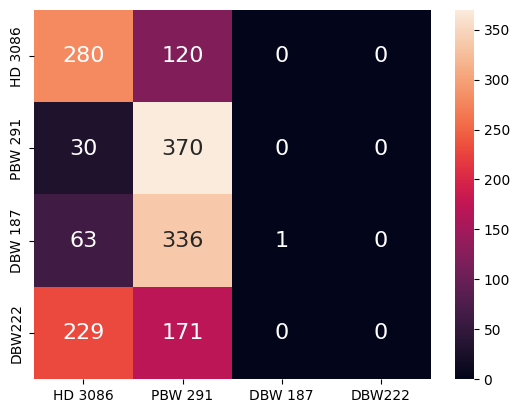

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()